In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
import json
import ast

In [90]:
color_mapping12 = {
    "C>A": "deepskyblue",
    "G>T": "deepskyblue",
    "C>G": "black",
    "G>C": "black",
    "C>T": "red",
    "G>A": "red",
    "T>A": "silver",
    "A>T": "silver",
    "T>C": "yellowgreen",
    "A>G": "yellowgreen",
    "T>G": "pink",
    "A>C": "pink",
}
sbs12_ordered = ["C>A", "G>T", "C>G", "G>C", "C>T", "G>A", "T>A", "A>T", "T>C", "A>G", "T>G", "A>C"]
colors12 = [color_mapping12[sbs] for sbs in sbs12_ordered]

In [91]:
df = pd.read_json('../data/other_virus_spectra.json')

In [92]:
df = df.T

In [93]:
df.index.name = 'virus_name'
df = df.reset_index()

In [94]:
virus_mitspec_df = pd.DataFrame()
for virus_name in list(df['virus_name']):
    virus_dict = ast.literal_eval(str(df.loc[df['virus_name']==virus_name, 
                                             'mutation_spectrum'].values).replace('[{','{').replace('}]','}').replace('to','>'))
    one_virus_dict = pd.DataFrame([virus_dict])
    virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
virus_mitspec_df['virus_name'] = list(df['virus_name'])

C:\Users\voron\AppData\Local\Temp\ipykernel_22068\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_22068\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_22068\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(one_virus_dict)
C:\Users\voron\AppData\Local\Temp\ipykernel_22068\2628477369.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_d

In [95]:
columns = list(virus_mitspec_df.columns)
columns.remove('virus_name')

In [96]:
virus_mitspec_df['total'] = virus_mitspec_df[columns].sum(axis=1)

In [97]:
for col in columns:
    virus_mitspec_df[col] = virus_mitspec_df[col]/virus_mitspec_df['total']
virus_mitspec_df = virus_mitspec_df.drop('total',axis=1)

In [98]:
mutspec_data = virus_mitspec_df.set_index('virus_name').stack().reset_index(name='rate').rename(columns={'level_1':'mut_type'})

In [99]:
mutspec_data

,virus_name,mut_type,rate
0,flu_h3n2,T>G,0.013431
1,flu_h3n2,C>T,0.196083
2,flu_h3n2,T>C,0.157439
3,flu_h3n2,A>G,0.131938
4,flu_h3n2,G>A,0.335605
...,...,...,...
151,WNV,T>A,0.027161
152,WNV,A>C,0.010195
153,WNV,G>T,0.026178
154,WNV,C>G,0.003357


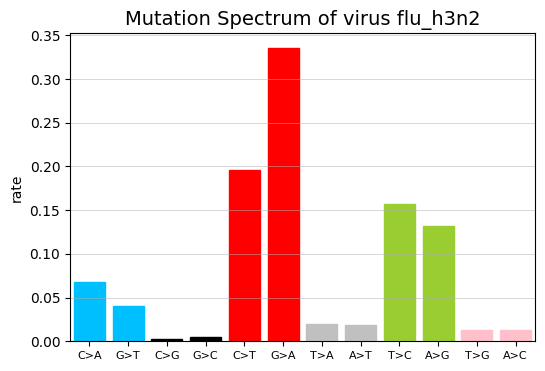

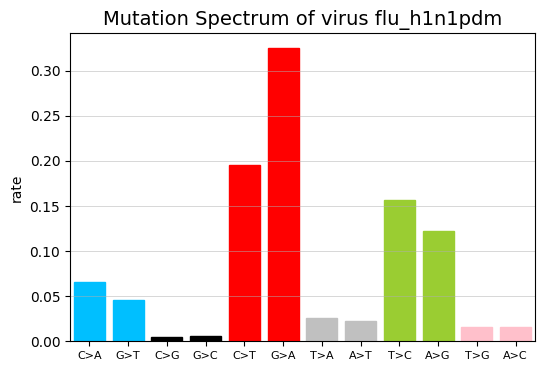

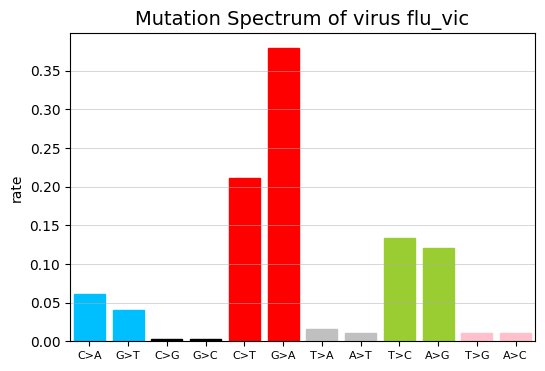

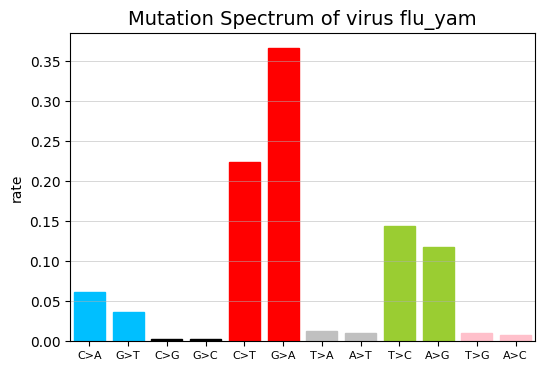

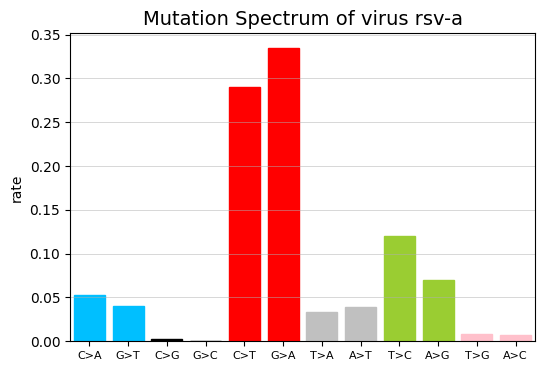

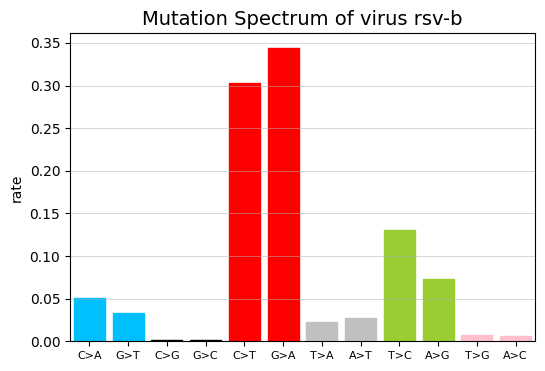

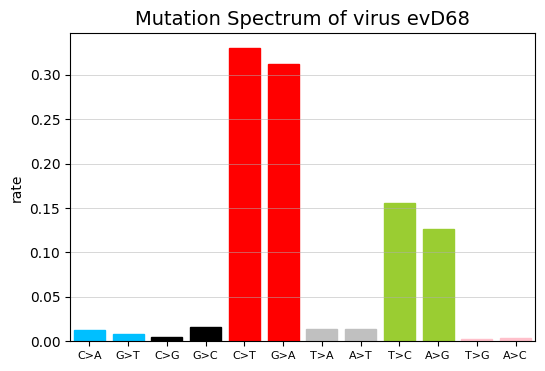

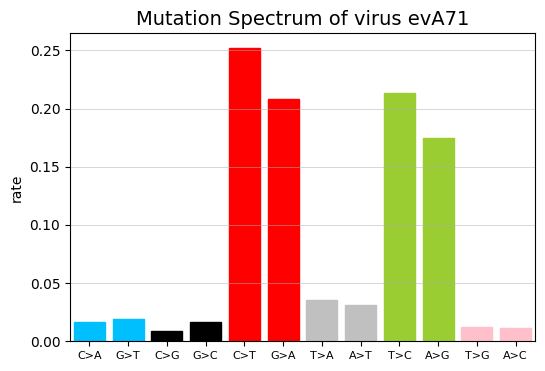

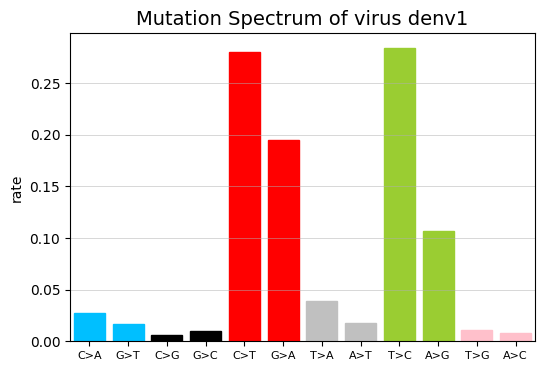

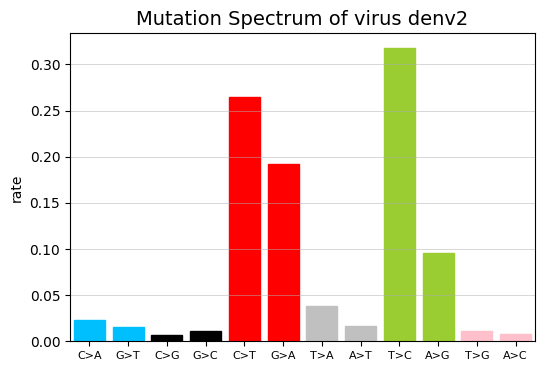

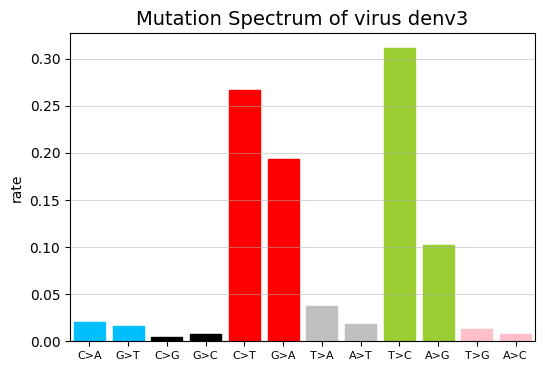

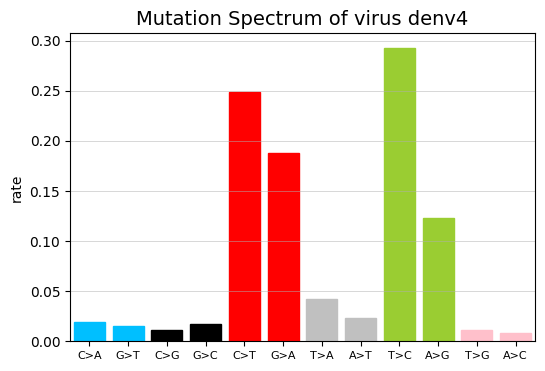

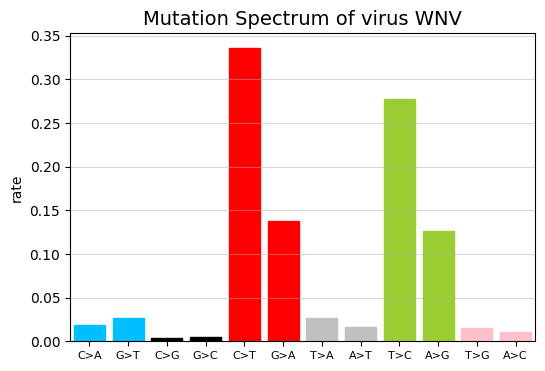

In [100]:
for virus in list(mutspec_data['virus_name'].unique()):
    one_virus_df = mutspec_data[mutspec_data['virus_name']==virus]
    fig = plt.figure(figsize=(6, 4))
    ax = sns.barplot(x="mut_type", y='rate', data=one_virus_df, order=sbs12_ordered, ax=fig.gca())
    ax.grid(axis="y", alpha=.7, linewidth=0.5)
    for bar, clr in zip(ax.patches, colors12):
        bar.set_color(clr)
    ax.set_title('Mutation Spectrum of virus '+virus, fontsize=14)
    ax.set_xlabel("")
    plt.xticks(fontsize=8)
    plt.show()
    plt.close()

In [101]:
clade_df = pd.read_csv('../data/rates_by_clade.csv')
clade_df = clade_df[['clade', 'mut_type', 'rate']]
clade_df['mut_type'] = clade_df['mut_type'].str.replace('to','>')
clade_df = clade_df[clade_df['clade']=='20A']
pca_df = clade_df.pivot(index='clade', columns='mut_type', values='rate').rename_axis(index=None, columns=None)
pca_df.index.name = 'virus_name'
pca_df = pca_df.reset_index()
pca_df['virus_name'] = 'SARS-CoV-2 20A'

columns = list(pca_df.columns)
columns.remove('virus_name')
pca_df['total'] = pca_df[columns].sum(axis=1)
for col in columns:
    pca_df[col] = pca_df[col]/pca_df['total']
pca_df = pca_df.drop('total',axis=1)

In [102]:
virus_mitspec_df = virus_mitspec_df.append(pca_df)

C:\Users\voron\AppData\Local\Temp\ipykernel_22068\3009096822.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  virus_mitspec_df = virus_mitspec_df.append(pca_df)


In [103]:
clade_names = virus_mitspec_df['virus_name']
pca_data_only = virus_mitspec_df.drop('virus_name', axis=1)
model = PCA(n_components=12).fit(pca_data_only)
pca_model = model.transform(pca_data_only)
#pca_model = pca.fit_transform(pca_data_only)
pca_data = pd.DataFrame(pca_model, columns=["pc"+str(i+1) for i in range(len(pca_data_only.columns))])
pca_data1 = pca_data[["pc1","pc2"]].copy()

In [104]:
categories = np.unique(virus_mitspec_df['virus_name'])
colors = np.linspace(0, 1, len(categories))
colordict = dict(zip(categories, colors))  
virus_mitspec_df["Color"] = virus_mitspec_df['virus_name'].apply(lambda x: colordict[x])

In [105]:
virus_mitspec_df = virus_mitspec_df.reset_index(drop=True)

In [106]:
virus_mitspec_df.loc[virus_mitspec_df['virus_name'].isin(['flu_h3n2',
 'flu_h1n1pdm',
 'flu_vic',
 'flu_yam',
 'rsv-a',
 'rsv-b']), "RNAsense"] = '- Rna'
virus_mitspec_df.loc[virus_mitspec_df['virus_name'].isin(['evD68',
 'evA71',
 'denv1',
 'denv2',
 'denv3',
 'denv4',
 'WNV',
 'SARS-CoV-2 20A']), "RNAsense"] = '+ Rna'

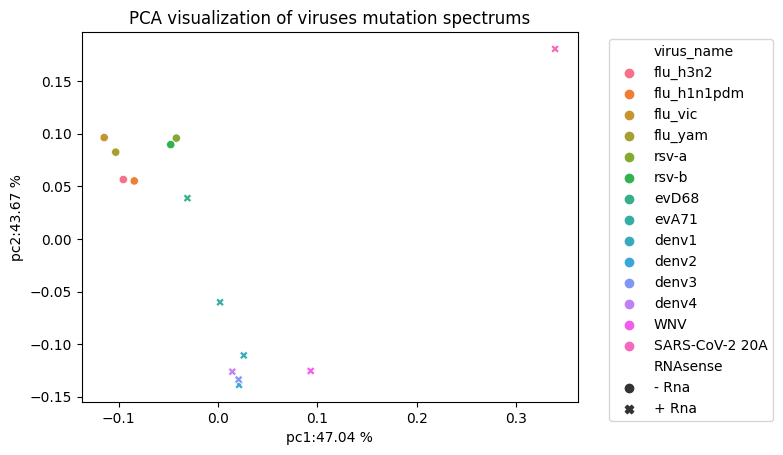

In [107]:
sns.scatterplot(data=pca_data1, 
                x="pc1", 
                y="pc2", 
               hue=virus_mitspec_df['virus_name'], style=virus_mitspec_df['RNAsense'])
plt.title("PCA visualization of viruses mutation spectrums")
plt.xlabel("pc1:" + "{:.2f}".format(pca.explained_variance_ratio_[0] * 100) + " %")
plt.ylabel("pc2:" + "{:.2f}".format(pca.explained_variance_ratio_[1] * 100) + " %")

plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
plt.close()

In [85]:
virus_mitspec_df

,T>G,C>T,T>C,A>G,G>A,A>T,C>A,T>A,A>C,G>T,C>G,G>C,virus_name,Color,RNAsense
0,0.013431,0.196083,0.157439,0.131938,0.335605,0.018434,0.067506,0.019876,0.013002,0.039958,0.002099,0.004628,flu_h3n2,0.692308,- Rna
1,0.015716,0.194899,0.156519,0.122620,0.325181,0.022171,0.066162,0.025369,0.015630,0.045243,0.004931,0.005561,flu_h1n1pdm,0.615385,- Rna
2,0.010400,0.211020,0.133855,0.120362,0.379445,0.011133,0.060726,0.016327,0.010306,0.040934,0.002884,0.002609,flu_vic,0.769231,- Rna
3,0.010085,0.223910,0.144512,0.117671,0.366943,0.010157,0.062121,0.013412,0.007849,0.036883,0.003053,0.003405,flu_yam,0.846154,- Rna
4,0.008174,0.290197,0.120245,0.070279,0.334728,0.038923,0.053017,0.033842,0.007703,0.040141,0.002418,0.000332,rsv-a,0.923077,- Rna
5,0.007654,0.302556,0.130986,0.073270,0.344073,0.027371,0.050217,0.022186,0.006557,0.032733,0.001255,0.001142,rsv-b,1.000000,- Rna
6,0.002727,0.330388,0.155263,0.126225,0.312351,0.014119,0.012983,0.013464,0.003692,0.008320,0.004277,0.016191,evD68,0.538462,+ Rna
7,0.012561,0.252110,0.213292,0.174782,0.207964,0.030948,0.016551,0.035659,0.011776,0.018932,0.009032,0.016392,evA71,0.461538,+ Rna
8,0.010890,0.280289,0.283934,0.106834,0.194708,0.017726,0.027413,0.038517,0.007765,0.016525,0.005921,0.009479,denv1,0.153846,+ Rna
9,0.011173,0.264785,0.317783,0.095366,0.191594,0.016655,0.022890,0.038259,0.008255,0.015754,0.006688,0.010799,denv2,0.230769,+ Rna


In [108]:
n_pcs= model.components_.shape[0]
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [116]:
initial_feature_names = list(pca_data_only.columns)

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}


df = pd.DataFrame(dic.items())

# Мутации которые более всего повлияли на компоненты

In [117]:
df

,0,1
0,PC1,G>A
1,PC2,T>C
2,PC3,C>T
3,PC4,A>G
4,PC5,A>T
5,PC6,C>A
6,PC7,G>C
7,PC8,T>A
8,PC9,A>C
9,PC10,C>G
